# Train a CNN

Convolutional neural networks (CNNs) are popular tools for creating automated machine learning classifiers on images or image-like samples. By converting audio into a two-dimensional frequency vs. time representation such as a spectrogram, we can generate image-like samples that can be used to train CNNs. 

This tutorial demonstrates the basic use of OpenSoundscape's `preprocessors` and `cnn` modules for training CNNs and making predictions using CNNs.

Under the hood, OpenSoundscape uses Pytorch for machine learning tasks. By using the class `opensoundscape.ml.cnn.CNN`, you can train and predict with PyTorch's powerful CNN architectures in just a few lines of code. 

## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

## Setup

### Import needed packages

In [1]:
# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape import CNN

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
import subprocess
from glob import glob
import sklearn

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [2]:
torch.manual_seed(50)
random.seed(50)
np.random.seed(50)

### Download files

Training a machine learning model requires some pre-labeled data. These data, in the form of audio recordings or spectrograms, are labeled with whether or not they contain the sound of the species of interest. 

These data can be obtained from online databases such as Xeno-Canto.org, or by labeling one's own ARU data using a program like Cornell's Raven sound analysis software. In this example we are using a set of annotated avian soundscape recordings that were annotated using the software Raven Pro 1.6.4 (Bioacoustics Research Program 2022):

<blockquote><i>An annotated set of audio recordings of Eastern North American birds containing frequency, time, and species information. </i> Lauren M. Chronister,  Tessa A. Rhinehart,  Aidan Place,  Justin Kitzes.
https://doi.org/10.1002/ecy.3329 
</blockquote>

These are the same data that are used by the annotation and preprocessing tutorials, so you can skip this step if you've already downloaded them there.

In [2]:
# Set the current directory to where the dataset is downloaded
dataset_path = Path("/home/dah238/Kauai-Amakihi/Annotations")

# Make a list of all of the csvs utilized
selection_files = glob(f"{dataset_path}/*/*.csv")
index_to_remove = 1 #this is specifically removing the combined_output_macaulay_v1.csv that i used for experiment 1
selection_files = selection_files[:index_to_remove] + selection_files[index_to_remove+1:]
train =pd.concat((pd.read_csv(selection_files[0]), pd.read_csv(selection_files[2])))
train['annotation'] = train['annotation'].replace([' KAAM_song','KAAM_wsong'],'KAAM_song')
train["annotation"].value_counts()

NameError: name 'Path' is not defined

In [ ]:
# if False:
#    masterlist = pd.DataFrame()
#    for i in range(len(selection_files)):
#       templist = pd.read_csv(selection_files[i])
#       templist['annotation_file'] = selection_files[i]
#       masterlist = pd.concat([masterlist, templist])
#    masterlist = masterlist.iloc(0:5)

In [10]:
selection_files

['/home/dah238/Kauai-Amakihi/Annotations/macaulay/combined_output_macaulay_v2.csv',
 '/home/dah238/Kauai-Amakihi/Annotations/akek_sam/sam_lapp_annotations.csv',
 '/home/dah238/Kauai-Amakihi/Annotations/xeno_canto/combined_output_xeno_canto.csv']

In [11]:
valid = pd.read_csv(selection_files[1])
train =pd.concat((pd.read_csv(selection_files[0]), pd.read_csv(selection_files[2])))
train['annotation'] = train['annotation'].replace([' KAAM_song','KAAM_wsong'],'KAAM_song')

In [12]:
valid["annotation"].value_counts()
#ensure that all KAAM_song are good and uniform

annotation
KAAM_song     107
0              93
ANIA_song      89
u              72
KAAM_song?     67
ANIA_song?     41
KAAM_ANIA      10
AKEK_song       9
AKEK_song?      8
AKEK_KAAM       8
playback        2
Name: count, dtype: int64

In [13]:
train["annotation"].value_counts()
#ensure that all KAAM_song are good and uniform

annotation
KAAM_song        313
KAAM_call         80
?                 20
?_KAAM_song       16
?_KAAM_call        7
?KAAM_song         6
?KAAM_call         1
  ?_KAAM_song      1
Name: count, dtype: int64

sam = valid

## Prepare audio data

To prepare audio data for machine learning, we need to convert our annotated data into clip-level labels.

These steps are covered in depth in other tutorials, so we'll just set our clip labels up quickly for this example.

First, get exactly matched lists of audio files and their corresponding selection files:

Next, convert the selection files and audio files to a `BoxedAnnotations` object, which contains the time, frequency, and label information for all annotations for every recording in the dataset.

In [ ]:
valid

In [ ]:
from opensoundscape import BoxedAnnotations
valid_boxed = BoxedAnnotations(df = valid, audio_files=valid["audio_file"])
# Create dataframe of one-hot labels
class_sub = ["KAAM_song"]

valid_clips = valid_boxed.clip_labels(
    clip_duration = 3,
    clip_overlap = 0,
    min_label_overlap = 0,
    audio_files = valid["audio_file"].unique(), #CHANGE THIS
    class_subset = class_sub
)
ann = valid_boxed.df[["audio_file", "start_time", "end_time"]]

def overlaps_any(row):
    a = ann[ann.audio_file == row.name[0]]
    return ((a.start_time < row.name[1] + 3) &
            (a.end_time > row.name[1])).any()

valid_clips = valid_clips[valid_clips.apply(overlaps_any, axis=1)]


train_boxed = BoxedAnnotations(df = train, audio_files=train["audio_file"])
train_clips = train_boxed.clip_labels(
    clip_duration = 3, 
    clip_overlap = 1.5,
    min_label_overlap = 0.5,
    audio_files = train["audio_file"].unique(),
    class_subset = class_sub
)

In [ ]:
valid_clips["KAAM_song"].value_counts()

## Create train, validation, and test datasets

To train and test a model, we use three datasets:

* The **training dataset** is used to fit your machine learning model to the audio data. 
* The **validation dataset** is a held-out dataset that is used to select hyperparameters (e.g. how many epochs to train for) during training
* The **test dataset** is another held-out dataset that we use to check how the model performs on data that were not available at all during training.

While both the training and validation datasets are used while training the model, the test dataset is never touched until the model is fully trained and completed.

The training and validation datasets may be gathered from the same source as each other. In contrast, the test dataset is often gathered from a different source to assess whether the model's performance generalizes to a real-world problem. For example, training and validation data might be drawn from an online database like Xeno-Canto, whereas the testing data is from your own field data. 

### Create a test dataset

We'll separate the test dataset first. For a good assessment of the model's generalization, we want the test set to be independent of the training and validation datasets. For example, we don't want to use clips from the same source recording in the training dataset and the test dataset.

For this example, we'll use the recordings in the folders `Recording_1`, `Recording_2` and `Recording_3` as our training and validation data, and use the recordings in folder `Recording_4` as our test data. 

In [ ]:
if False:
    from sklearn.model_selection import train_test_split

    train_df, val_df = train_test_split(clip_labels,test_size=0.2)
    train_df.shape,val_df.shape


If you wanted, you could load the training and testing set from these saved CSV files.

In [ ]:
if False:
    train_and_val_set = pd.read_csv("./annotated_data/train_and_val_set.csv", index_col=[0, 1, 2]
    )
    test_set = pd.read_csv("./annotated_data/test_set.csv", index_col=[0, 1, 2])

### Split training and validation datasets

Now, separate the remaining non-test data into training and validation datasets.

The idea of keeping a separate validation dataset is that, throughout training, we can 'peek' at the performance on the validation set to choose hyperparameters. (This is in contrast to the test dataset, which we will not look at until we've finished training our model.)

One important hyperparameter is the number of **epochs** to train to, in order to prevent overfitting. Each epoch includes one round of fitting on each training sample. 

If a model's performance on a training dataset continues to improve as it trains, but its performance on the validation dataset plateaus, this could incate the model is **overfitting** on the training dataset, learning information specific to those particular samples instead of gaining the ability to generalize to new data.

In [ ]:
# # Split our training data into training and validation sets
# train_df, valid_df = sklearn.model_selection.train_test_split(
#     train_and_val_set, test_size=0.1, random_state=0
# )

In [ ]:
if False:
    train_clips.to_csv("Experiment4a/train_set.csv")
    valid_clips.to_csv("Experiment4a/valid_set.csv")

***look back to reorganize file save locations, EDIT THIS EVERY EXPERIMENT***

In [ ]:
if False:
    train_df = pd.read_csv("Experiment4/train_set.csv", index_col=[0,1,2])
    valid_df = pd.read_csv("Experiment4/valid_set.csv", index_col=[0,1,2])

### Resample data for even class representation

Before training, we will balance the number of samples of each class in the training set. This helps the model learn all of the classes, rather than paying too much attention to the classes with the most labeled annotations. 

In [85]:
train_df.KAAM_song.value_counts()

KAAM_song
False    1267
True      905
Name: count, dtype: int64

SPECIFIC CODE FOR EXPERIMENT 4A

In [86]:
from opensoundscape.data_selection import resample
bal_train_df =  resample(train_df, n_samples_per_class= train_df.KAAM_song.value_counts().values[0], random_state = 0)
bal_train_df.KAAM_song.value_counts()


KAAM_song
True     1267
False    1267
Name: count, dtype: int64

## Set up model

Now we create a model object. We have to select several parameters when creating this object: its `architecture`, `classes`, and `sample_duration`. 

Some additional parameters can also be changed at this step, such as the preprocessor used to create spectrograms and the shape of the spectrograms. 

For more detail on this step, see the ["Customize CNN training"]("tutorials/CNN.html") tutorial.


### Create CNN object

Now, create a CNN object with this architecture, the classes we put into the dataframe above, and the same sample duration as we selected above.

The first time you run this script for a particular architecture, OpenSoundscape will download the desired architecture.

In [ ]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet34 architecture
architecture = "resnet18"

# Can use this code to get your classes, if needed
class_list = list(train_df.columns)
clip_duration = 3

model = CNN(
    architecture=architecture,
    classes=class_list,
    sample_duration=clip_duration,  # 3s, selected above
)

### Check model device

If a GPU is available on your computer, the CNN object automatically selects it for accellerating performance. You can override `.device` to use a specific device such as `cpu` or `cuda:3`

In [ ]:
print(f"model.device is: {model.device}")
model.device = "cuda:0"
print(f"model.device is: {model.device}")

### Set up WandB model logging

While this step is optional, it is very helpful for model training. In this step, we set up model logging on a service called **Weights & Biases** (AKA WandB). 

Weights & Biases is a free website you can use to monitor model training. It is integrated with OpenSoundscape to include helpful functions such as checking on your model's training progress in real time, visualizing the spectrograms created for training your model, comparing multiple tries at training the same model, and more. For more information, check out this [blog post](https://wandb.ai/wandb_fc/repo-spotlight/reports/Community-Spotlight-OpenSoundscape--Vmlldzo0MDcwMTI4). 

The instructions below will help you set up `wandb` logging:

* Create an account on the [Weights and Biases website](https://wandb.ai/). 
* The first time you use `wandb`, you'll need to run `wandb.login()` in Python or `wandb login` on the command line, then enter the API key from your [settings](https://wandb.ai/settings) page
* In a Python script where you want to log model training, use `wandb.init()` as demonstrated below. The "Entity" or team option allows runs and projects to be shared across members in a group, making it easy to collaborate and see progress of other team members' runs.


As training progresses, performance metrics will be plotted to the wandb logging platform and visible on this run's web page. For example, this [wandb web page](https://wandb.ai/kitzeslab/opensoundscape%20training%20demo/runs/w1xyk7zr/workspace?workspace=user-samlapp) shows the content logged to wandb when this notebook was run by the Kitzes Lab. By default, OpenSoundscape + WandB integration creates several pages with information about the model:

- Overview: hyperparameters, run description, and hardware available during the run
- Charts: "Samples" panel with audio and images of preprocessed samples (useful for checking that your preprocessing performs as expected and your labels are correct)
- Charts: graphs of each class's performance metrics over training time
- Model: summary of model architecture
- Logs: standard output of training script
- System: computational performance metrics including memory, CPU use, etc

When training several models and comparing performance, the "Project" page of WandB provides comparisons of metrics and hyperparameters across training runs.

In [ ]:
import wandb

try:
    wandb.login()
    wandb_session = wandb.init(
        entity="kitzeslab",  # replace with your entity/group name
        project="KAAM",
        name="experiment4a",
    )
except:  # if wandb.init fails, don't use wandb logging
    print("failed to create wandb session. wandb session will be None")
    wandb_session = None

## Train the CNN

Finally, train the CNN for two epoch. Typically, we would train the model for more than two epochs, but because training is slow and is much better done outside of a Jupyter Notebook, we just include this as a short demonstration of training.

Each **epoch** is one pass-through of all of the samples in the training dataset, plus running predictions on the validation dataset. 

Each epoch is composed of smaller groups of samples called **batches**. The machine learning model predicts on every sample in the batch, then the model weights are updated based on those samples. Larger batches can increase training speed, but require more memory. If you get a memory error, try reducing the batch size.

We use default training parameters, but many aspects of CNN training can be customized (see the "Customize CNN training" tutorial for examples).

In [ ]:
checkpoint_folder = Path("Experiment4a/checkpoints")
checkpoint_folder.mkdir(exist_ok=True)
#CHANGE CHECKPOINT FOLDER PATH

In [ ]:
%%capture --no-stdout --no-display
# Uncomment the line above to silence outputs from this cell
num_workers = 4
model.train(
    train_df = bal_train_df,
    validation_df = valid_df,
    epochs=20, #change to more later
    batch_size=124,
    log_interval=1000,  # log progress every 100 batches
    num_workers=num_workers,  # parallelized cpu tasks for preprocessing
    wandb_session=wandb_session,
    save_interval=10,  # save checkpoint every 10 epochs
    save_path=checkpoint_folder,  # location to save checkpoints
)

Once this is finished running, you have trained the CNN. 

To generate predictions on audio files using the CNN, use the `.predict()` method of the CNN object. Here, we apply a sigmoid activation layer which maps the CNN's outputs (all real numbers) to a 0-1 range. 

None , "Sigmoid"

In [ ]:
scores_df = model.predict(valid_df, activation_layer=None)
valid_df["scores"] = scores_df["KAAM_song"]


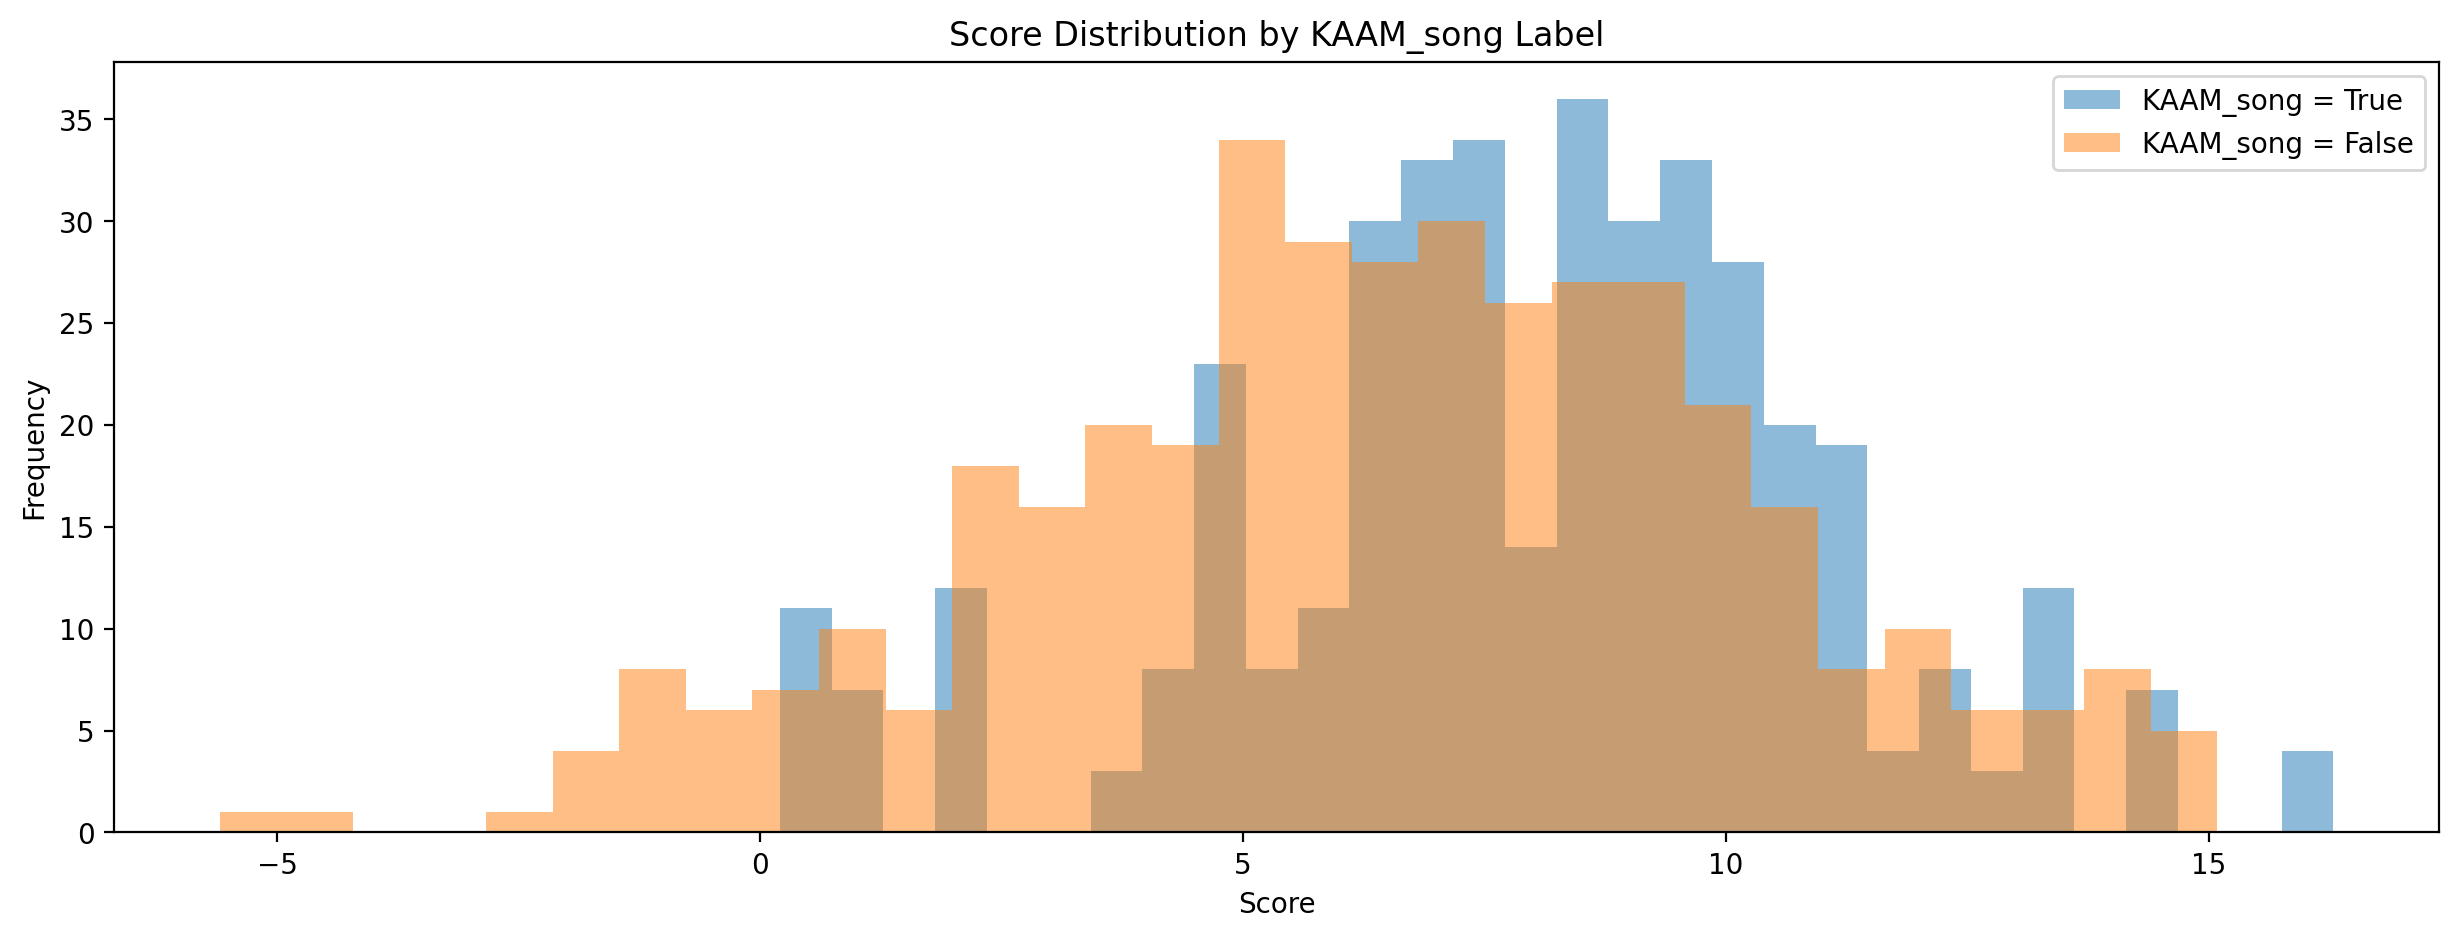

In [87]:
true_scores = valid_df.loc[valid_df["KAAM_song"], "scores"]
false_scores = valid_df.loc[~valid_df["KAAM_song"], "scores"]

plt.hist(true_scores, bins=30, alpha=0.5, label="KAAM_song = True")
plt.hist(false_scores, bins=30, alpha=0.5, label="KAAM_song = False")

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Score Distribution by KAAM_song Label")
plt.legend()
plt.show()

valid_df.to_csv("Experiment4a/scores_df.csv")
